In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import concatenate, LeakyReLU, BatchNormalization, Dense, Activation, Reshape
from keras.optimizers import *
from keras.datasets import mnist

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

(X_train, _), (_, _) = mnist.load_data()
X_train = np.reshape(X_train, (-1, 28, 28, 1))/255

Using TensorFlow backend.


In [2]:
from typing import List
from tensorflow.python.framework.ops import Tensor
from unet import unet_cell # Local import

In [3]:
# Note: Support for type hints only in Python >= 3.5
def build_upscaler(inputs: Input,
                   num_filters_in_layer: List[int]=[16, 32, 64],
                   num_cells_in_layer: List[int]=[3, 3, 3],
                   bottleneck_before_concat: bool=False) -> Model:
    """Build a model which upscales inputs by factor of 4 (i.e., 
       doubles the height and width of inputs)
    
    # Arguments
    
    # Returns
    """
    # Validate inputs
    if len(num_filters_in_layer) != len(num_cells_in_layer):
        raise ValueError(f"len(num_filters_in_layer) should equal "
            "len(num_cells_in_layer). Received lengths: "
            "{(len(num_filters_in_layer), len(num_cells_in_layer)}")
    
    x = inputs
    x = UpSampling2D()(x)
    carry_forward_tensors = []

    # Zip the parameters that apply to the contraction-side (exclude last 
    # parameter for bottom layer)
    contraction_filters_and_cells = zip(num_filters_in_layer[:-1],
                                        num_cells_in_layer[:-1])

    # Contraction
    for i, (num_filters, num_cells) in enumerate(contraction_filters_and_cells):
        if i == 0:
            # First layer does not downsample
            for j in range(num_cells):
                x = unet_cell(x, num_filters=num_filters) 
                # Note: We make extensive use of default values.
        else:
            # Downsample first
            x = unet_cell(x, num_filters=num_filters, strides=2)
            for j in range(num_cells - 1):
                x = unet_cell(x, num_filters=num_filters)
        carry_forward_tensors.append(x)

    # Bottom layer
    num_filters_at_bottom = num_filters_in_layer[-1]
    num_cells_at_bottom = num_cells_in_layer[-1]

    x = unet_cell(x, num_filters=num_filters_at_bottom, strides=2)
    for i in range(num_cells_at_bottom - 1):
        x = unet_cell(x, num_filters=num_filters_at_bottom)

    # Expansion
    filters_cells_and_carrys = reversed(list(zip(num_filters_in_layer[:-1],
                                                 num_cells_in_layer[:-1],
                                                 carry_forward_tensors)))
    for num_filters, num_cells, carry in filters_cells_and_carrys:
        x = unet_cell(x, transpose_conv=True, num_filters=num_filters, strides=2)
        if bottleneck_before_concat:
            x = unet_cell(x, num_filters=num_filters//2, kernel_size=1)
            carry = unet_cell(carry, num_filters=num_filters//2, kernel_size=1)
        x = concatenate([x, carry])
        for _ in range(num_cells - 1):
            x = unet_cell(x, num_filters=num_filters)

    # Output
    x = unet_cell(x, num_filters=1, kernel_size=1, activation='sigmoid',
                  batch_normalization=False)

    model = Model(inputs=inputs, outputs=x)
    return model

In [2]:
def build_generator():
    input1 = Input(shape=(None, None, 1))
    
    input11 = UpSampling2D()(input1)
    
    # [C L B C L B]
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(input11)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    
    # [C L B C L B C L B]
    model2 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(model1)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)
    model2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model2)
    model2 = LeakyReLU(alpha=0.2)(model2)
    model2 = BatchNormalization(momentum=0.8)(model2)

    # [C L B C L B C L B]
    model3 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(model2)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)
    model3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model3)
    model3 = LeakyReLU(alpha=0.2)(model3)
    model3 = BatchNormalization(momentum=0.8)(model3)

    # [Conc L B C L B C L B]
    model4 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(model3), model2], axis=3)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    model4 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(model4)
    model4 = LeakyReLU(alpha=0.2)(model4)
    model4 = BatchNormalization(momentum=0.8)(model4)
    
    # [Conc L B C L B C L B]
    model5 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(model4), model1], axis=3)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    model5 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(model5)
    model5 = LeakyReLU(alpha=0.2)(model5)
    model5 = BatchNormalization(momentum=0.8)(model5)
    
    # [Conc L B C_sigmoid]
    model6 = concatenate([Conv2D(16, (1, 1), padding='same')(model5), input11], axis=3)
    model6 = LeakyReLU(alpha=0.2)(model6)
    model6 = BatchNormalization(momentum=0.8)(model6)
    model6 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(model6)
    
    return Model(inputs=input1, outputs=model6)

In [4]:
# TODO: Test keras.applications (ResNet, Xception, etc.) as discriminators
def build_discriminator():
    # TODO: Do we need two inputs?
    input1 = Input(shape=(None, None, 1))
    input2 = Input(shape=(None, None, 1))
    

    # input1 is upsampled, then taken through two unet_cells
    model1 = UpSampling2D()(input1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)

    # input2 is taken directly through two unet_cells
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(input2)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    
    # The two resulting tensors are then concatenated.
    model = concatenate([model, model1], axis=3)
    
    model = Conv2D(32, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    
    model = Conv2D(128, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = GlobalAveragePooling2D()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Dense(512)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)

    return Model(inputs=[input1, input2], outputs=model)

In [5]:
x = Input(shape=(None, None, 1))
# Note: dimensions of x should probably be divisible by 2**{num_layers}

# generator = build_generator()
generator = build_upscaler(x) # Use default parameters

optimizer = Adam(0.001, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer1 = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

discriminator.trainable = False

# The generator takes noise as input and generated imgs
img = generator(x) # Calling the model on y (the upscaled input)

# The discriminator takes two arguments: 
#     1) the original image, and 
#     2) the output of the generator (which should be a 
#        realistically upsampled version of the original)
valid = discriminator([x, img])

# The combined model  (stacked generator and discriminator) takes
# low-res image as input and returns an upsampled image from the generator and a 
# validity score given by the discriminator
combined = Model(x, [valid, img])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], optimizer=optimizer, metrics = ['accuracy'])

# Note that the combined model was compiled *after* freezing the discriminator's weights

combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, None, None, 1 179969      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            1824769     input_1[0][0]                    
                                                                 model_1[1][0]                    
Total params: 2,004,738
Trainable params: 179,009
Non-trainable params: 1,825,729
__________________________________________________________________________________________________


0 [D loss: 0.656232, acc.: 68.00%] [G loss: 1.238466]


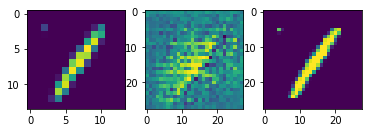

10 [D loss: 0.599339, acc.: 72.00%] [G loss: 1.739717]


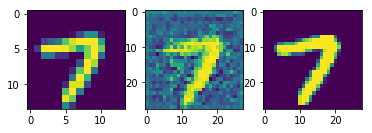

20 [D loss: 0.537681, acc.: 74.00%] [G loss: 2.363772]


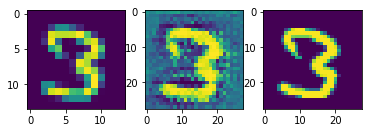

30 [D loss: 0.116845, acc.: 100.00%] [G loss: 2.250146]


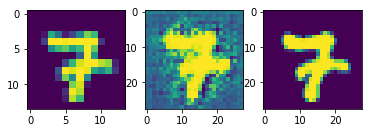

40 [D loss: 0.046421, acc.: 100.00%] [G loss: 3.459740]


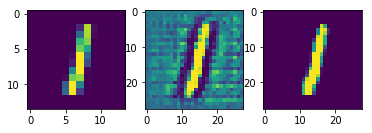

50 [D loss: 0.059262, acc.: 100.00%] [G loss: 3.711539]


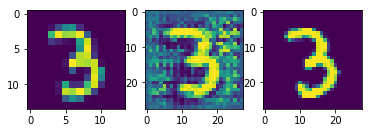

60 [D loss: 0.615952, acc.: 76.00%] [G loss: 3.177828]


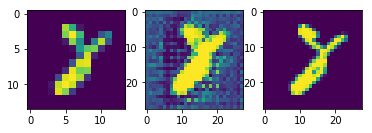

In [ ]:
epochs = 100
batch_size = 50
half_batch = int(batch_size/2)
def reduce_resolution(ims):
    O, M, N, P = ims.shape
    K = 2
    L = 2

    MK = M // K
    NL = N // L
    return ims.reshape(-1, MK, K, NL, L).mean(axis=(2, 4)).reshape(O, MK, NL, P)

# Unused function...?
def upsize(ims):
    return ims.repeat(2, axis = 1).repeat(2, axis = 2)

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = reduce_resolution(imgs) # imgs dimensions should be divisible by 2?
    # TODO: Probably should change some of the variable names to something more accurate.

    idx1 = np.random.randint(0, X_train.shape[0], half_batch)
    imgs1 = X_train[idx1]
    noise1 = reduce_resolution(imgs1)

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise1)
    # gen_imgs are now upsampled to original resolution
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([noise, imgs], np.ones((half_batch, 1)))
    # Recall: imgs are random selection of actual MNIST images
    #    and noise = reduce_resolution(imgs)
    
    d_loss_fake = discriminator.train_on_batch([noise1, gen_imgs], np.zeros((half_batch, 1)))
    # Recall: noise1 = reduce_resolution(imgs1)
    #    and gen_imgs = generator(noise1)
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    idx2 = np.random.randint(0, X_train.shape[0], batch_size)
    noise2 = reduce_resolution(X_train[idx2])

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the generator
    g_loss = combined.train_on_batch(noise2, [valid_y, X_train[idx2]])
        
    if epoch % 10 == 0:
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(np.reshape(noise1[0], (14, 14)))
        ax[1].imshow(np.reshape(gen_imgs[0], (28, 28)))
        ax[2].imshow(np.reshape(imgs1[0], (28, 28)))
        plt.show()


In [6]:
generator.save('./models/generator_mnist.h5')
discriminator.save('./models/discriminator_mnist.h5')
combined.save('./models/combined_mnist.h5')